In [368]:
import scipy.io
import numpy as np
import math as m
import eeglearn

from scipy.interpolate import griddata
from sklearn.preprocessing import scale
from eeglearn.utils import augment_EEG, cart2sph, pol2cart

In [369]:
def gen_images(locs, features, n_gridpoints, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = int(features.shape[1] / nElectrodes)
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    nSamples = features.shape[0]
    
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
        
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
            
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
        
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = scale(temp_interp[c][~np.isnan(temp_interp[c])])
        #temp_interp[c] = np.nan_to_num(temp_interp[c])

    # swap axes to have [samples, colors, W, H]
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     

In [370]:
def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.
    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)

    
# Load electrode locations
print('Loading data...')
locs = scipy.io.loadmat('C:/Users/UNIST/.jupyter/EEGLearn/Sample data/Neuroscan_locs_orig.mat')
locs_3d = locs['A']
locs_2d = []
# Convert to 2D
for e in locs_3d:
    locs_2d.append(azim_proj(e))

Loading data...


In [371]:
feats = scipy.io.loadmat('./EEGLearn/Sample data/FeatureMat_timeWin.mat')['features']
subj_nums = np.squeeze(scipy.io.loadmat('./EEGLearn/Sample data/trials_subNums.mat')['subjectNum'])

In [372]:
# Leave-Subject-Out cross validation
fold_pairs = []

for i in np.unique(subj_nums):
    ts = subj_nums == i
    tr = np.squeeze(np.nonzero(np.bitwise_not(ts)))
    ts = np.squeeze(np.nonzero(ts))
    np.random.shuffle(tr)  # Shuffle indices
    np.random.shuffle(ts)
    fold_pairs.append((tr, ts))

In [373]:
feats.shape

(2670, 1345)

In [571]:
from functools import reduce
    
# CNN Mode
print('Generating images...')
# Find the average response over time windows
av_feats = reduce(lambda x, y: x+y, [feats[:, i*192:(i+1)*192] for i in range(int((feats.shape[1]) / 192))])
av_feats = av_feats / ((feats.shape[1]-1) / 192)
images = gen_images(np.array(locs_2d),
                              av_feats,
                              20, normalize=True)
print('\n')

Generating images...
Interpolating 2670/2670terpolating 46/2670Interpolating 71/2670Interpolating 96/2670Interpolating 122/2670Interpolating 145/2670Interpolating 169/2670Interpolating 194/2670Interpolating 220/2670Interpolating 247/2670Interpolating 271/2670Interpolating 297/2670Interpolating 321/2670Interpolating 345/2670Interpolating 370/2670Interpolating 393/2670Interpolating 417/2670Interpolating 441/2670Interpolating 467/2670Interpolating 494/2670Interpolating 519/2670Interpolating 544/2670Interpolating 570/2670Interpolating 595/2670Interpolating 621/2670Interpolating 647/2670Interpolating 673/2670Interpolating 695/2670Interpolating 719/2670Interpolating 746/2670Interpolating 771/2670Interpolating 796/2670Interpolating 819/2670Interpolating 845/2670Interpolating 871/2670Interpolating 897/2670Interpolating 923/2670Interpolating 949/2670Interpolating 972/2670Interpolating 998/2670Interpolating 1024/2670Interpolating 1051/2670Interpolating 1077/2670Interpolating 1101/2670Interpolati

In [572]:
def NanMinMaxScaler(X):
    a = X.shape[1]
    
    if X.ndim > 1:
        X = X.flatten()
        
    X_nanstd = (X - np.nanmin(X, axis=0)) / (np.nanmax(X, axis=0) - np.nanmin(X, axis=0))
    X_nanScaled = X_nanstd * (1 - 0) + 0
    
    X_nanScaled = X_nanScaled.reshape(a, -1)
    
    return X_nanScaled

(2670, 3, 20, 20)


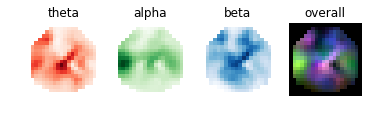

In [573]:
print(images.shape)

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize

#num_dat = np.random.randint(2000)
num_dat = 1
img = np.copy(images[num_dat])
img = img.swapaxes(1,2) # X & Y axes flip

# theta
plt.subplot(141)
plt.imshow(img[0], cmap='Reds')
plt.gca().invert_yaxis() # Y axis invert
plt.title('theta')
plt.axis('off')

# alpha
plt.subplot(142)      
plt.imshow(img[1], cmap='Greens')
plt.gca().invert_yaxis()
plt.title('alpha')
plt.axis('off')

# beta
plt.subplot(143)
plt.imshow(img[2], cmap='Blues')
plt.gca().invert_yaxis()
plt.title('beta')
plt.axis('off')


# overall
# norm (~RGB 각각)
for c in range(3):
    img[c] = NanMinMaxScaler(img[c])    

#nan to zero
img = np.nan_to_num(img)

plt.subplot(144)
img = np.transpose(img, [1,2,0])
plt.imshow(img)
plt.gca().invert_yaxis() # Y axis invert
plt.title('overall')
plt.axis('off')

plt.savefig('./eeg_gen_topo/' + str(num_dat) + '.png')